# 타이타닉 생존자 분석
* RMS 타이타닉은 영국의 화이트 스타 라인이 운영한 북대서양 횡단 여객선으로, 1912년 4월 10일 첫 출항하였다. 영국의 사우샘프턴을 떠나 미국의 뉴욕으로 향하던 중에 4월 15일 빙산과 충돌하여 침몰하였으며, 이로 인해 1,514명이 사망한 것으로 알려져 있다.
* 타이타닉 데이터를 분석하여 생존에 영향을 준 요인을 파악하고, 이를 바탕으로 **생존 여부를 예측하는 모델**을 학습해보자.

## 1. 데이터셋
+ [데이터] seaborn에서 제공하는 1900년대 타이타닉 탑승자들에 대한 데이터를 제공함.
+  타이타닉 생존여부에 영향을 미치는 요인은 무엇인지 파악하고,생존여부를 분류하는 모델을 학습시키고자 함.
+ 총 891개의 관측값과 15개의 독립변수(feature), 1개의 종속변수(target)으로 구성됨

## 2. 데이터 확인 및 전처리

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 데이터 불러오기

df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
df.info()    # 데이터 확인시 중복되는 변수나, 불필요한 변수는 제거할것임.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


* 타이타닉 데이터를 확인한 결과, 관측값은 891 개, 변수는 15개로 나타남.
* 타이타닉호 생존에 영향을 미치는(feature)은 다음과 같음
  * pclass 객실등급(1,2,3)
  * sex    성별
  * age    나이
  * sibsp  함께 탐승한 형제자매, 배우자 수 
  * parch  함께 탑승한 부모, 자식수
  * fare   요금
  * embarked 탑승항구(S,C,Q)
  * deck   갑판
  * who    사람구분(man,woman,child)
   
* 종속변수( target) 는 'survived'임

In [4]:
# 데이터 전처리 :(1) 타이타닉 생존여부에 영향을 미치는 feature 선택
df1 = df[['survived','pclass','sex','age','sibsp','parch','fare','embarked','deck','who']].copy()
df1.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,deck,who
0,0,3,male,22.0,1,0,7.2500,S,NaN,man
1,1,1,female,38.0,1,0,71.2833,C,C,woman
2,1,3,female,26.0,0,0,7.9250,S,NaN,woman
3,1,1,female,35.0,1,0,53.1000,S,C,woman
4,0,3,male,35.0,0,0,8.0500,S,NaN,man


In [5]:
# 데이터 전처리: (2) 결측값 확인
df1.isna().sum()

survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
deck        688
who           0
dtype: int64

In [6]:
# 'age' 결측값 처리 : 중앙값으로 대체.

df1['age'] = df1['age'].fillna(df1['age'].median())

# 'deck' 결측값 처리 : 결측값이 너무 많아 제거.

df1.drop('deck', axis=1, inplace=True)

# 'embarked' 결측값 처리: 최빈값으로 대체.

df1['embarked'] = df1['embarked'].fillna(df1['embarked'].mode()[0])



In [7]:
df1.isna().sum()   # 결측값 제거 확인

survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
who         0
dtype: int64

<br>

## 3.데이터 분할 : 학습데이터, 평가데이터 

* 학습 데이터와 평가 데이터를 7:3 비율로 분할함
* 타이타닉 데이터는 크기가 작기 때문에 7:3(train:test) 분할이  적절

In [8]:
# 학습/평가 데이터 분할(7:3비율)
# Feature, Target 분리
X = df1.drop('survived', axis=1)      #feature
y = df1['survived']                   #target

# 학습/평가 데이터 분할 (7:3 비율

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
X_train

,pclass,sex,age,sibsp,parch,fare,embarked,who
445,1,male,4.0,0,2,81.8583,S,child
650,3,male,28.0,0,0,7.8958,S,man
172,3,female,1.0,1,1,11.1333,S,child
450,2,male,36.0,1,2,27.7500,S,man
314,2,male,43.0,1,1,26.2500,S,man
...,...,...,...,...,...,...,...,...
106,3,female,21.0,0,0,7.6500,S,woman
270,1,male,28.0,0,0,31.0000,S,man
860,3,male,41.0,2,0,14.1083,S,man
435,1,female,14.0,1,2,120.0000,S,child


In [10]:
y_train

445    1
650    0
172    1
450    0
314    0
      ..
106    1
270    0
860    0
435    1
102    0
Name: survived, Length: 623, dtype: int64

<br>

## 4. 데이터 탐색

In [11]:
# 요약통계량 확인

df1_train = pd.concat([X_train,y_train],axis = 1)
df1_train.head()

,pclass,sex,age,sibsp,parch,fare,embarked,who,survived
445,1,male,4.0,0,2,81.8583,S,child,1
650,3,male,28.0,0,0,7.8958,S,man,0
172,3,female,1.0,1,1,11.1333,S,child,1
450,2,male,36.0,1,2,27.7500,S,man,0
314,2,male,43.0,1,1,26.2500,S,man,0


In [12]:
# 한글 깨짐 현상에 대한 해결 방법
import matplotlib as mpl
plt.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False

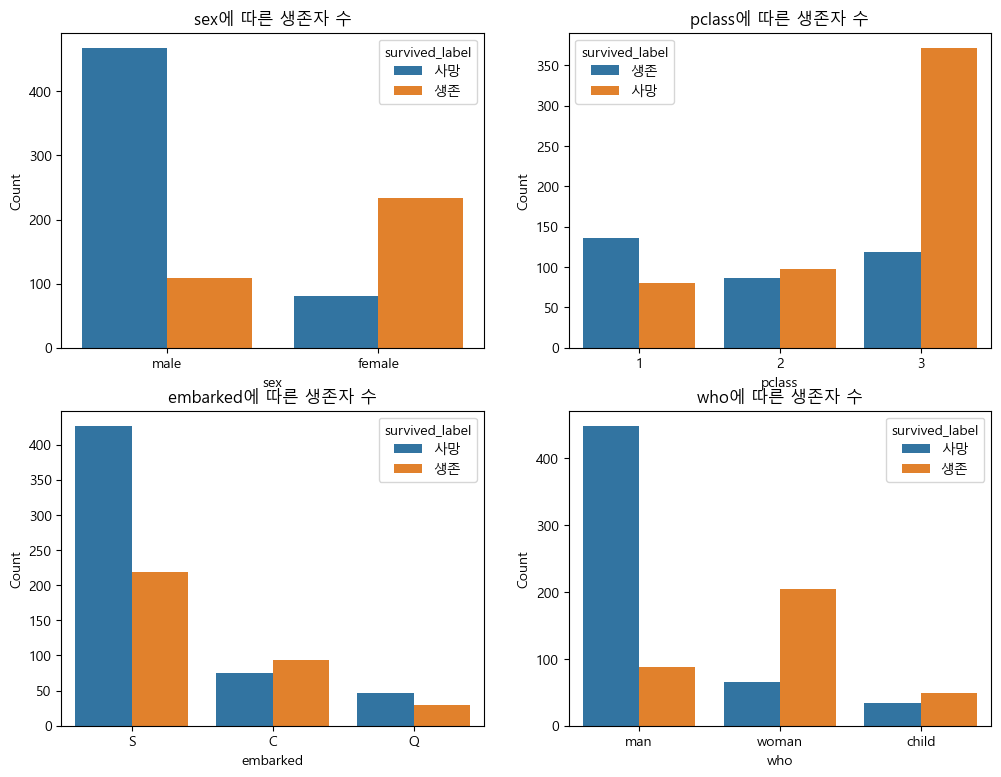

In [13]:
df1['survived_label'] = df1['survived'].map({0: '사망', 1: '생존'})

# 시각화할 변수
cat_features = ['sex', 'pclass', 'embarked', 'who']

plt.figure(figsize=(12,9))

for i, feature in enumerate(cat_features):
    plt.subplot(2, 2, i + 1)
    ax = sns.countplot(x=feature, hue='survived_label', data=df1)
    plt.title(f'{feature}에 따른 생존자 수')
    plt.ylabel('Count')


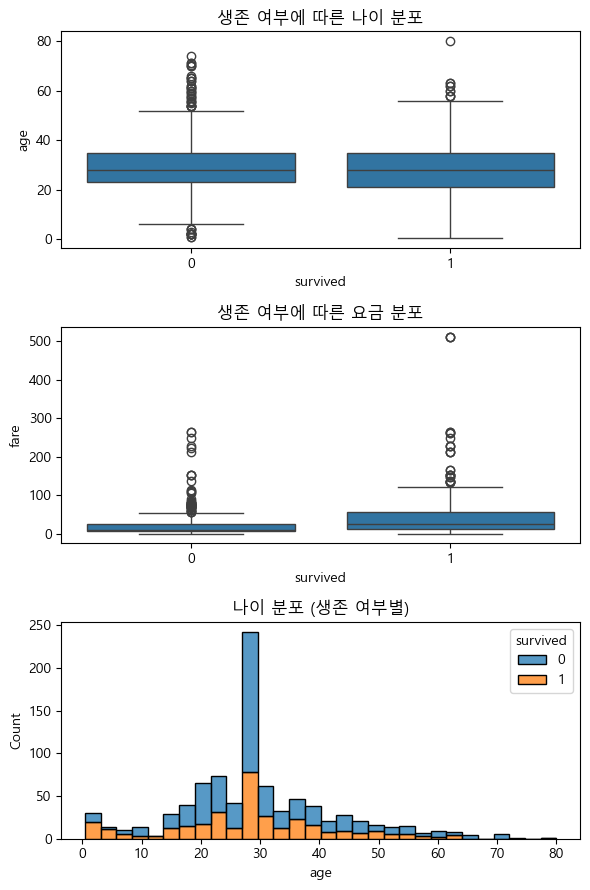

In [14]:
# Figure 생성 (3행 1열)
fig, axes = plt.subplots(3, 1, figsize=(6,9))

# 1. 생존 여부에 따른 나이 분포 (boxplot)
sns.boxplot(x='survived', y='age', data=df1, ax=axes[0])
axes[0].set_title('생존 여부에 따른 나이 분포')

# 2. 생존 여부에 따른 요금 분포 (boxplot)
sns.boxplot(x='survived', y='fare', data=df1, ax=axes[1])
axes[1].set_title('생존 여부에 따른 요금 분포')

# 3. 나이 히스토그램 (생존 여부별)
sns.histplot(data=df1, x='age', hue='survived', multiple='stack', ax=axes[2])
axes[2].set_title('나이 분포 (생존 여부별)')

# 레이아웃 정리
plt.tight_layout()
plt.show()


* 데이터 해석
* 1. 성별 (sex)에 따른 생존자 수는 여성 승객의 생존자 수가 남성보다 월등히 많았다. 특히 여성은 사망자보다 생존자가 많았지만, 남성은 사망자가 압도적으로 많았다.
     이는 **여성과 아이를 먼저 구조**하는 원칙이 실제 구조 과정에 반영되었음을 보여준다.
* 2. 객실 등급 (pclass)에 따른 생존자 수는  1등급 승객의 생존률이 가장 높았고, 3등급 승객은 사망자가 더 많았다.
     이는 상위 계층이 구조에 더 빠르게 접근할 수 있었거나, 위치상 구조가 용이했을 가능성을 시사한다.

* 3. 탑승 항구 (embarked)에 따른 생존자 수는 **Cherbourg(C항)**에서 탑승한 승객의 생존률이 높았으며, Southampton(S항) 탑승자는 수는 많았지만 사망률도 높았다.
     항구별 승객의 계층 구성 혹은 배치 구조가 생존에 영향을 준 것으로 해석할 수 있다.

* 4. 사람 유형 (who)에 따른 생존자 수는 who 변수로 구분된 woman, child는 생존률이 매우 높았고, 반면 man은 생존률이 가장 낮았다.
     이 역시 구조 우선 순위가 여성과 아동에게 있었음을 다시 한 번 보여준다.

* 5. 나이 (age)와 생존 여부 박스플롯과 히스토그램 분석 결과, 어린 승객일수록 생존 확률이 높은 경향을 보였으며, 노년층은 생존률이 낮았다.
     구조 순서와 신체 조건 등 다양한 요인이 작용했을 것으로 판단된다.

* 6. 요금 (fare)과 생존 여부
     생존자들은 평균적으로 더 높은 요금을 지불한 경향이 있었다.
     요금은 객실 등급과 밀접한 관련이 있으므로, 상위 계층일수록 생존률이 높았음을 다시 확인할 수 있다.

## 5.분류  모델 학습

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [16]:
# 0. 범주형 변수 숫자로 변환
df1['sex'] = df1['sex'].map({'female': 0, 'male': 1})
df1['embarked'] = df1['embarked'].map({'S': 0, 'C': 1, 'Q': 2})
df1['who'] = df1['who'].map({'child': 0, 'woman': 1, 'man': 2})

In [17]:
# 1. Feature/Target 분리
X = df1.drop(['survived', 'survived_label'], axis=1)  # survived 제외
y = df1['survived']  # target은 0/1

# 2. 학습/평가 데이터 분할 (7:3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [18]:
# 3. 최적의 k 찾기
k_range = range(1, 20, 2)  # 1, 3, 5, ..., 19
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
    print(f"k = {k}일 때 평균 정확도: {scores.mean():.3f}")



k = 1일 때 평균 정확도: 0.668
k = 3일 때 평균 정확도: 0.701
k = 5일 때 평균 정확도: 0.701
k = 7일 때 평균 정확도: 0.703
k = 9일 때 평균 정확도: 0.711
k = 11일 때 평균 정확도: 0.708
k = 13일 때 평균 정확도: 0.713
k = 15일 때 평균 정확도: 0.709
k = 17일 때 평균 정확도: 0.714
k = 19일 때 평균 정확도: 0.708


In [19]:
# 4. 최적의 k 선택
best_k = k_range[k_scores.index(max(k_scores))]
print(f"\n✅ 최적의 k값은 {best_k}이며, 평균 정확도는 {max(k_scores):.3f}")


✅ 최적의 k값은 17이며, 평균 정확도는 0.714


In [20]:
# 5. 최적의 k로 최종 모델 학습
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

,n_neighbors,17
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [21]:
# 6. 예측 및 평가
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [22]:
print(f"\n📊 최종 평가 결과 (k={best_k})")
print(f"정확도: {accuracy:.3f}")
print(f"정밀도: {precision:.3f}")
print(f"재현도: {recall:.3f}")


📊 최종 평가 결과 (k=17)
정확도: 0.713
정밀도: 0.750
재현도: 0.459


## 6. 분류 모델 평가
* 타이타닉 생존자 예측을 위해 K-NN 분류 모델을 적용하였으며, 교차 검증(cross-validation)을 통해 모델의 성능을 비교한 결과, k=17일 때 가장 높은 정확도를 기록하여 해당 값을 최적의 하이퍼파라미터로 선정하였다.
* 최종적으로 학습된 K-NN 모델에 대해 테스트 데이터를 기반으로 성능을 평가한 결과는 다음과 같다:

  **정확도**는 0.713으로, 전체 테스트 샘플 중 약 71.3%를 올바르게 분류하였다. 이는 모델이 전체적으로는 비교적 안정적인 예측 성능을 갖추고 있음을 의미한다.

  **정밀도**는 0.750으로, 생존자(1)로 예측한 대상 중 실제로 생존자인 비율이 75%에 달한다. 즉, 모델이 생존자라고 판단한 예측은 상당히 신뢰할 수 있는 편이다.

   반면, **재현율**은 0.459로 비교적 낮게 나타났다. 이는 실제 생존자 중 약 45.9%만을 모델이 생존자라고 제대로 예측했다는 의미로, 모델이 생존자를 놓치는 경우가 상당수 존재함을 시사한다.
종합적으로 볼 때, 해당 K-NN 모델은 생존자 예측에 있어서 정밀도는 높지만, 재현율이 낮은 보수적인 성향의 분류 모델로 해석할 수 있다. 이는 모델이 생존자임을 신중하게 판단하려는 경향이 있으며, 그로 인해 실제 생존자를 일부 놓치는 현상이 발생하는 것이다